## read me

This file can process both resting state data and event related potentials. For the second, it's important that the data has event markers created with the script in the bitbrain importing section. 

Set variable **erp** to true or false to determine if you want to process event related potentials (True) or resting state data (false)

In [134]:
%load_ext autoreload
%autoreload 2
%matplotlib qt
%matplotlib inline


import numpy as np
import csv
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
import autoreject
from tqdm import tqdm 
from atpbar import atpbar
from datetime import datetime
import mne
from autoreject import AutoReject
from mne.preprocessing import ICA, corrmap, create_ecg_epochs, create_eog_epochs

from pyprep.find_noisy_channels import NoisyChannels
from mne_icalabel import label_components
from scipy.stats import ttest_rel
from mne.stats import permutation_cluster_1samp_test
from matplotlib.colors import Normalize
from mne.viz import plot_topomap
import matplotlib.ticker as ticker



mne.set_log_level('ERROR')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import LTP epochs

In [72]:
evokeds = {}
for time in ['pre', 'post']:
    evokeds[time] = {}
    for condition in ['baseline', 'early', 'late']:
        evokeds[time][condition] = {}
            
        evokeds[time][condition]['std'] = []
        evokeds[time][condition]['dev'] = []
        evokeds[time][condition]['dif'] = []

        for sub in [0,1,2,3,4,5,7,8,9]: # sub 6 is missing this: "epochs_ar/sub6_pre_late_epo.fif"
            
            path = f'epochs_ar/sub{sub}_{time}_{condition}_epo.fif'
    
            epochs = mne.read_epochs(path)
            epochs.interpolate_bads(reset_bads=True).pick_types(eeg=True).filter(l_freq=None, h_freq=40)
    
            #reject_criteria = dict(eeg=50e-6)
            #epochs.drop_bad(reject=reject_criteria)
            
            evokeds[time][condition]['std'].append(epochs['1'].average())
            evokeds[time][condition]['dev'].append(epochs['-1'].average())
            evokeds[time][condition]['dif'].append(mne.combine_evoked([evokeds[time][condition]['dev'][-1], evokeds[time][condition]['std'][-1]], weights=[1, -1]))           


## Create group averages

In [73]:
# Creating the evoked responses

evo_group = {}

for time in ['pre', 'post']:
    evo_group[time] = {}
    for condition in ['baseline', 'early', 'late']:
        evo_group[time][condition] = {}
        for stimulus in ['std', 'dev', 'dif']:
            evo_group[time][condition][stimulus] = mne.combine_evoked(evokeds[time][condition][stimulus], weights='equal')


In [127]:
time

'post'

In [132]:
a = evo_group['pre']['baseline']['std']
b = evo_group['pre']['early']['std']
c = evo_group['pre']['late']['std']
d = evo_group['pre']['baseline']['dev']
e = evo_group['pre']['early']['dev']
f = evo_group['pre']['late']['dev']

g = evo_group['post']['baseline']['std']
h = evo_group['post']['early']['std']
i = evo_group['post']['late']['std']
j = evo_group['post']['baseline']['dev']
k = evo_group['post']['early']['dev']
l = evo_group['post']['late']['dev']

grand_average = mne.combine_evoked([a,b,c,d,e,f,g,h,i,j,k,l], weights='equal')


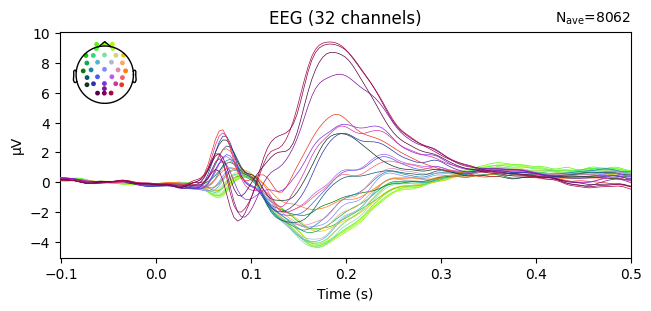

In [133]:
grand_average.plot()

Bottom: Oz, POz, O2 (O1, Pz, but much smaller)  
Top: O2, Oz, O1, POz

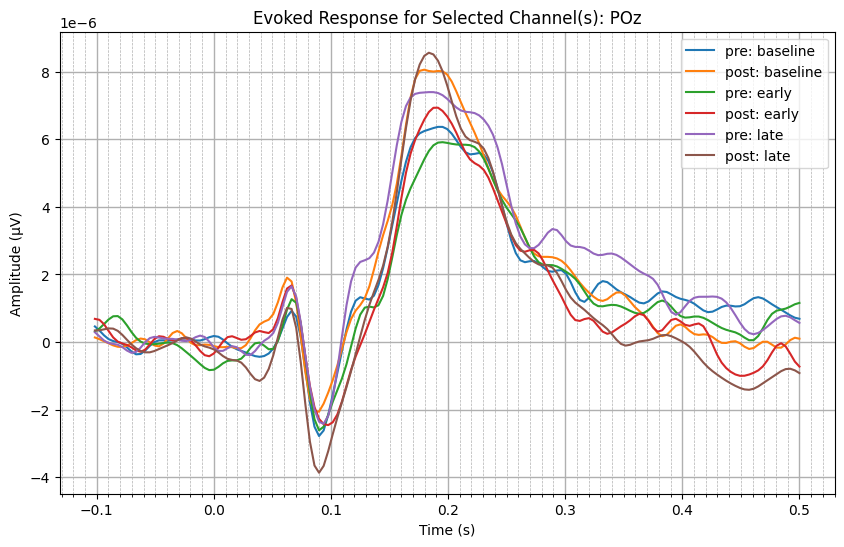

In [171]:

# Specify the channel(s) to visualize
selected_channel = ['POz']

# Extract the evoked data for the specified conditions
conditions = ['baseline', 'early', 'late']

plt.figure(figsize=(10, 6))
for condition_n, condition in enumerate(['baseline', 'early', 'late']):
    for timepoint in (['pre', 'post']):
        evoked = evo_group[timepoint][condition]['dev'].copy()
        evoked.pick_channels(selected_channel)
        if len(evoked.data.shape) == 2:
            data = evoked.data.mean(axis=0)
        else:
            data = evoked.data
        times = evoked.times
        plt.plot(times, data, label=f"{timepoint}: {condition}")

# Customize the plot
plt.title(f"Evoked Response for Selected Channel(s): {', '.join(selected_channel)}")
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (µV)')
plt.legend(loc='upper right')

# Set grid properties
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(0.1))  # Major ticks every 0.02 s
plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(0.01))  # Minor ticks every 0.01 s
plt.grid(True, which='major', linestyle='-', linewidth=1.0)  # Thicker for major grid lines
plt.grid(True, which='minor', linestyle='--', linewidth=0.5)  # Thinner for minor grid lines

plt.show()

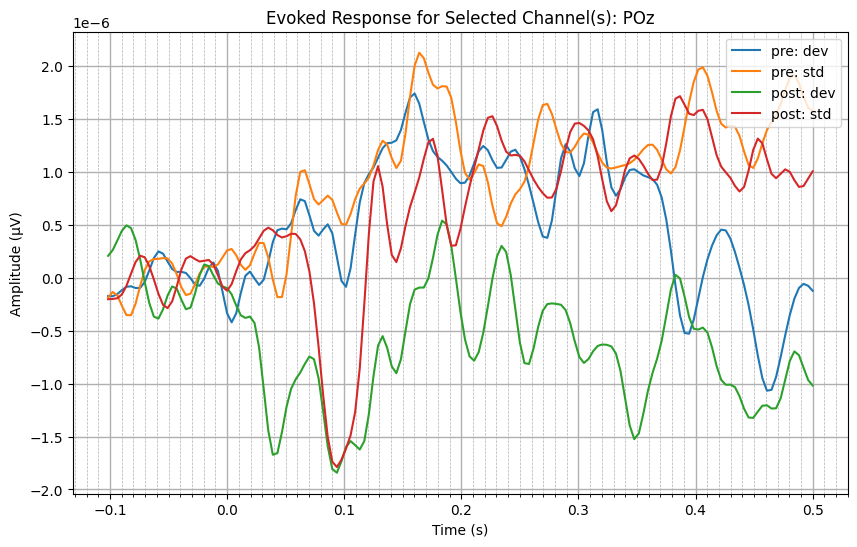

In [169]:

# Specify the channel(s) to visualize
selected_channel = ['POz']

# Extract the evoked data for the specified conditions
conditions = ['baseline', 'early', 'late']

plt.figure(figsize=(10, 6))
for timepoint in (['pre', 'post']):
    for stimulus in ['dev', 'std']:
        evoked_baseline = evo_group[timepoint]['baseline'][stimulus].copy()
        evoked_late = evo_group[timepoint]['late'][stimulus].copy()
        evoked_dif = mne.combine_evoked([evoked_baseline, evoked_late], weights=[-1, 1])
        evoked_dif.pick_channels(selected_channel)

    
        if len(evoked_dif.data.shape) == 2:
            data = evoked_dif.data.mean(axis=0)
        else:
            data = evoked_dif.data
        times = evoked.times
        plt.plot(times, data, label=f"{timepoint}: {stimulus}")

# Customize the plot
plt.title(f"Evoked Response for Selected Channel(s): {', '.join(selected_channel)}")
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (µV)')
plt.legend(loc='upper right')

# Set grid properties
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(0.1))  # Major ticks every 0.02 s
plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(0.01))  # Minor ticks every 0.01 s
plt.grid(True, which='major', linestyle='-', linewidth=1.0)  # Thicker for major grid lines
plt.grid(True, which='minor', linestyle='--', linewidth=0.5)  # Thinner for minor grid lines

plt.show()

## paired sample ttests

In [172]:
tmin = 0.08
tmax = 0.09
selected_channel = ['POz']
timepoint = 'pre'
condition = 'late'

a = []
b = []
for i in range(9): 
    a_new = float(evokeds[timepoint][condition]['std'][i].copy().crop(tmin=tmin, tmax=tmax).pick_channels(selected_channel).get_data().mean())
    a.append(a_new)
    b_new = float(evokeds[timepoint][condition]['dev'][i].copy().crop(tmin=tmin, tmax=tmax).pick_channels(selected_channel).get_data().mean())
    b.append(b_new)

t_stat, p_value = ttest_rel(a, b)
print(p_value)

0.5159279011873372


## Cluster based permutation test

Doesn't reveal any significance, likely because it smears out the very spatially and temporally localised effects

In [87]:
# function to cut the evokeds array
def cut_array(evokeds_array, start,end, channel_selection=None, channel_names=None):
    start_samp = int(np.round((start+0.1)*256))
    end_samp = int(np.round((end+0.1)*256))
    
    if channel_selection == None: 
        evokeds_array_t = evokeds_array[:,:,:,:,start_samp:end_samp, :]   
    else:
        channel_indices = [channel_names.index(ch) for ch in channel_selection if ch in channel_names]
        evokeds_array_t = evokeds_array[:,:,:,start_samp:end_samp, channel_indices]   
    return (evokeds_array_t)


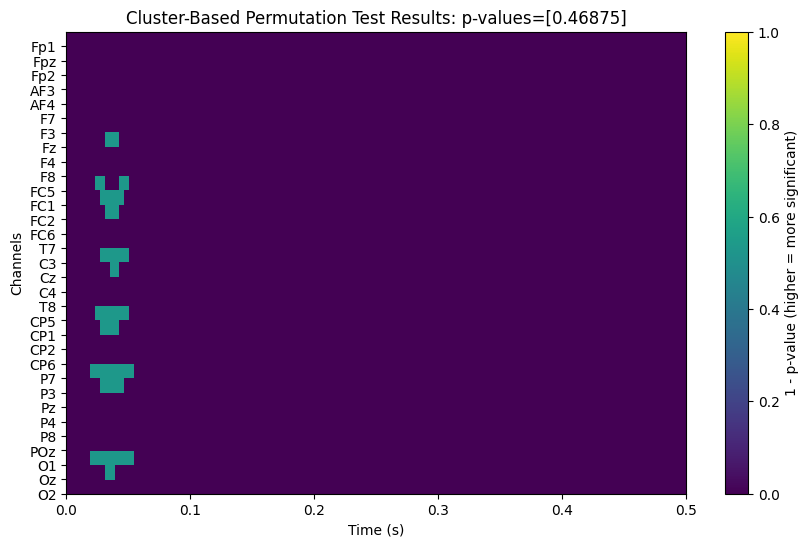

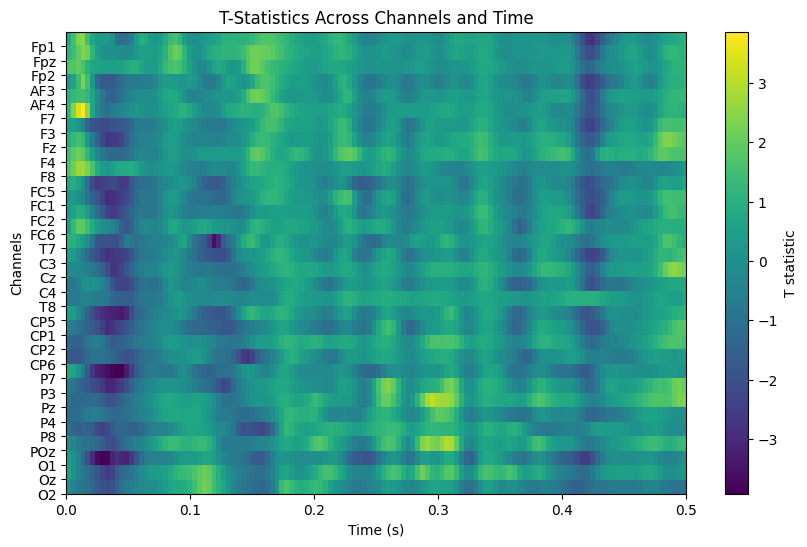

significant_indices:
[ 7 10 11 12 15 16 19 20 23 24 29 30]


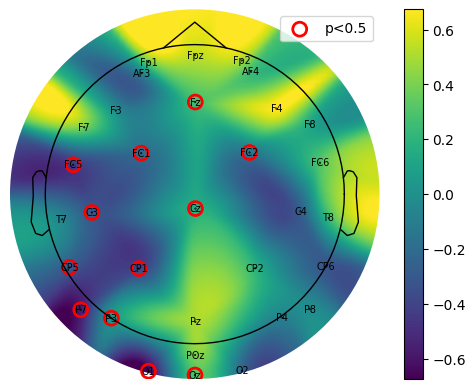

In [109]:
start = 0
end = 0.5
p_threshold = 0.5

sample_n = len(evokeds['pre']['late']['std'][0].get_data().T)
ch_adjacency, channel_selection = mne.channels.find_ch_adjacency(evokeds['pre']['late']['std'][0].info, 'eeg')

evokeds_array = np.zeros([9,2,3,3,sample_n,len(channel_selection)])
for sub in range(9):
    for day_n, day in enumerate(['pre', 'post']):
        for timepoint_n, timepoint in enumerate (['baseline', 'early', 'late']):
            for condition_n, condition in enumerate(['std','dev','dif']):
                evokeds_array[sub,day_n, timepoint_n, condition_n,:,:] = evokeds[day][timepoint][condition][sub].copy().pick_channels(channel_selection).get_data().T
evokeds_array_t = cut_array(evokeds_array, start, end)

# sub   day(pre, post)   timepoint (baseline, early, late)   condition (std, dev, dif)   timepoints   channels
X_diff = evokeds_array_t[:, 1, 1, 0, :, :] - evokeds_array_t[:, 1, 1, 1, :, :]  # Shape: (10, n_channels, n_timepoints)

T_obs, clusters, cluster_p_values, H0 = permutation_cluster_1samp_test(
    X_diff, threshold=None, n_permutations=8192, tail=0, adjacency=ch_adjacency
)



time_series = [
    [evokeds_array[:, 1, 2, 0, :, :].mean(axis=(0,2)), 'normal', 'dashdot'],
    [evokeds_array[:, 1, 2, 1, :, :].mean(axis=(0,2)), 'tetanized', 'dashdot'],
]


###########################
### 2D Plot of clusters ###
###########################


# Input variables: T_obs, clusters, cluster_p_values
n_channels, n_times = T_obs.T.shape

# Define the sampling rate and time window
sampling_rate = 256  # Hz

# Calculate time points in seconds
times = np.linspace(start, end, n_times)

# Initialize a 2D matrix for visualization
cluster_matrix = np.zeros((n_channels, n_times))

# Populate the matrix with cluster p-values
for i, cluster in enumerate(clusters):
    p_val = cluster_p_values[i]
    if p_val < p_threshold:  # Only include significant clusters
        for t, ch in zip(cluster[0], cluster[1]):
            cluster_matrix[ch, t] = 1 - p_val  # Higher intensity for smaller p-values

# Create the plot
plt.figure(figsize=(10, 6))
norm = Normalize(vmin=0, vmax=1)  # Normalize values between 0 and 1
plt.imshow(cluster_matrix, 
           aspect='auto', 
           cmap='viridis', 
           norm=norm,
           origin='upper', 
           extent=[times[0], times[-1], 0, n_channels])

# Add channel labels
plt.yticks(ticks=np.arange(n_channels), labels=channel_selection[::-1])

# Add colorbar for p-value gradient
cbar = plt.colorbar()
cbar.set_label("1 - p-value (higher = more significant)")

# Label axes
selected_cluster_p = cluster_p_values[cluster_p_values<p_threshold]
plt.title(f"Cluster-Based Permutation Test Results: p-values={selected_cluster_p}")
plt.xlabel("Time (s)")
plt.ylabel("Channels")
plt.show()



##########################
### 2D Plot of T-Stats ###
##########################


# Input variables: T_obs
n_channels, n_times = T_obs.T.shape
sampling_rate = 256  # Hz

# Calculate time points in seconds
times = np.linspace(start, end, n_times)


# Create the plot
plt.figure(figsize=(10, 6))
plt.imshow(T_obs.T, aspect='auto', 
           #cmap='coolwarm', 
           origin='upper',
           extent=[times[0], times[-1], 0, n_channels])

plt.yticks(ticks=np.arange(n_channels), labels=channel_selection[::-1])

cbar = plt.colorbar()
cbar.set_label("T statistic")

# Label axes
plt.title("T-Statistics Across Channels and Time")
plt.xlabel("Time (s)")
plt.ylabel("Channels")
plt.show()






################################
### Find significant indices ###
################################

# Find significant clusters
significant_clusters = np.where(cluster_p_values < p_threshold)[0]

# Extract significant channel indices
significant_channels = []  # Use a set to avoid duplicates
for cluster_idx in significant_clusters:
    cluster = clusters[cluster_idx]    
    significant_channels.append(cluster[1])

significant_indices = np.unique(np.concatenate(significant_channels))
print ('significant_indices:')
print(significant_indices)

######################
### Plot topo maps ###
######################

# get positions for topo maps:
montage = mne.channels.make_standard_montage('standard_1020')
selected_channels = [ch for ch in montage.ch_names if ch in channel_selection]
selected_positions = np.array([montage.get_positions()['ch_pos'][ch][:2] for ch in selected_channels])



fig, ax = plt.subplots()
im, _ = plot_topomap(
    T_obs.mean(axis=0), 
    pos=selected_positions, 
    names=channel_selection,
    axes=ax,
    cmap='viridis', 
    contours=0,
    show=False  # Prevent automatic display
)

# Overlay significant channels with bold markers
for idx in significant_indices:
    ax.scatter(
        selected_positions[idx, 0], 
        selected_positions[idx, 1], 
        s=100,  # Marker size
        edgecolor='red',  # Outline color
        facecolor='none',  # Hollow circle
        linewidth=2,  # Line thickness for boldness
        label=f'p<{p_threshold}' if idx == significant_indices[0] else None  # Add label only once
    )

# Add legend for significant channels
ax.legend(loc='upper right')

# Display the plot
plt.colorbar(im, ax=ax)
plt.show()
